Implémentez un modèle de scoring

#Chargement du fichier

In [35]:
import pandas as pd

#le fichier CSV 
df = pd.read_csv('df_clean.csv', sep = ',')

In [36]:
df.shape

(356251, 770)

#Les valeurs manquantes

In [37]:
#le pourcentage des valeurs manquantes pour chaque colonne
valeur_m_p = df.isnull().mean() * 100

#les colonnes avec plus de 70% de valeurs manquantes
valeur_m_cols = valeur_m_p[valeur_m_p > 70].index

#le nombre de colonnes avec plus de 70% de valeurs manquantes
nb_valeur_m_cols = valeur_m_cols.shape[0]
print(f"Le nombre de colonnes avec plus de 70% de valeurs manquantes: {nb_valeur_m_cols}")

Le nombre de colonnes avec plus de 70% de valeurs manquantes: 144


In [38]:
#le nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

TARGET                                  48744
AMT_ANNUITY                                36
AMT_GOODS_PRICE                           278
DAYS_EMPLOYED                           64648
OWN_CAR_AGE                            235239
                                        ...  
CC_NAME_CONTRACT_STATUS_Signed_MAX     252693
CC_NAME_CONTRACT_STATUS_Signed_MEAN    252693
CC_NAME_CONTRACT_STATUS_Signed_SUM     252693
CC_NAME_CONTRACT_STATUS_Signed_VAR     253385
CC_COUNT                               252693
Length: 590, dtype: int64


In [39]:
#la suppression des colonnes avec plus de 70% de valeurs manquantes
df = df.drop(columns=valeur_m_cols)

print(f"Le nombre de colonnes restantes après suppression: {df.shape[1]}")
print(f"Le nombre de colonnes supprimées: {len(valeur_m_cols)}")

Le nombre de colonnes restantes après suppression: 626
Le nombre de colonnes supprimées: 144


In [40]:
#le df à utiliser pour la classification binaire (la prédiction de deux catégorie: 0 ou 1 ): df_classification il contient des nan

#je ne garde que les donneées où la colonne 'TARGET' n'est pas vide.
# 'TARGET' est la variable à prédire (classification binaire), donc ces données sont nécessaires pour l'entraînement
df_classification_binaire = df[df['TARGET'].notnull()]
print(df_classification_binaire.shape)

(307507, 626)


#Imputation

In [41]:
#je remplace les valeurs manquantes par la MOYENNE des colonnes numériques 
df = df_classification_binaire.copy()
df.fillna(df_classification_binaire.mean(), inplace=True)

In [42]:
df.shape

(307507, 626)

#Entrainement des modèle de classification 

##Avec l'algorithme LightGBM

###Suppression des caractères spéciaux

In [43]:
#df sans les caractères spéciaux dans les noms de colonnes

#lightGBM ne prend pas en charge les caractères spéciaux dans les noms de colonnes donc je les supprime
import re

#la fonction pour nettoyer les noms de colonnes
def clean_column_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
    return df

#j'applique la fonction à df
df = clean_column_names(df)

#maintenant les colonnes ne contiennent plus de caractères spéciaux

###Sample

In [44]:
#pour obtenir un échantillon stratifié en fonction de la distribution de la classe

# La taille de l'échantillon total
sample_size = 10000

#je calcule la proportion des classes
class_distribution = df['TARGET'].value_counts(normalize=True)

#l'échantillon stratifié en fonction de la distribution de 'TARGET'
df_sample = df.groupby('TARGET', group_keys=False).apply(lambda x: x.sample(int(sample_size * class_distribution.loc[x.name]), random_state=42))

#la distribution dans l'échantillon
print(df_sample['TARGET'].value_counts(normalize=True))

TARGET
0.0    0.919292
1.0    0.080708
Name: proportion, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_3968\3449317132.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('TARGET', group_keys=False).apply(lambda x: x.sample(int(sample_size * class_distribution.loc[x.name]), random_state=42))


###L'entrainement du modèle initial

In [45]:
import logging
import time
import pandas as pd
import numpy as np
import gc
import mlflow
import optuna
import matplotlib.pyplot as plt
import joblib  # Pour sauvegarder le modèle et le scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

###Configuration de base

In [46]:
#le logger Optuna pour optimiser les hyperparamètres du modèle 
logging.getLogger('optuna').setLevel(logging.CRITICAL)

#démarrage du chronomètre pour voir combien de temps l’entraînement va prendre
start_time = time.time()

#MLflow va enregistrer toutes les expériences sous le nom "LightGBM" (sur l'interface avec:  mlflow ui)
mlflow.set_experiment('LightGBM')

<Experiment: artifact_location='file:///c:/Users/HP/OneDrive/Documents/P7_opc/mlruns/207987867335832650', creation_time=1728991963494, experiment_id='207987867335832650', last_update_time=1728991963494, lifecycle_stage='active', name='LightGBM', tags={}>

###Séparation des features de la cible Target

In [47]:
'''#séparation des features et la cible "target" 

#x: les features à utiliser pour prédire
X = df_sample.drop(columns=["TARGET", "SK_ID_CURR"])

#la cible à prédire
y = df_sample["TARGET"]'''

#séparation des features et la cible "target" 
X = df_sample.drop(columns=["TARGET"])
y = df_sample["TARGET"]

###La division des données

In [48]:
#division initiale des données : 80% pour X_restant (train) et 20% pour X_nouveaux_clients (API)
X_restant, X_nouveaux_clients, y_restant, y_nouveaux_clients = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_restant = X_restant.drop(columns=["SK_ID_CURR"])

###Standardisation des données et enregistrement du scaler

In [50]:
#je standardise les données (les 80% (x_restant)) (les valeurs => sur la même échelle :moyenne = 0, écart-type = 1) pour aider le modèle à mieux apprendre
scaler = StandardScaler()
X_restant_scaled = scaler.fit_transform(X_restant)

#je maintient le df pour les indices
X_restant_scaled = pd.DataFrame(X_restant_scaled, index=X_restant.index, columns=X_restant.columns)

#enregistrement du scaler pour une utilisation ultérieure dans l'API
joblib.dump(scaler, 'C:/Users/HP/OneDrive/Documents/P7_opc/api/scaler.joblib')

['C:/Users/HP/OneDrive/Documents/P7_opc/api/scaler.joblib']

###division des données d'entrainement qui sont standarisés pour données entrainement initial (20%) et final (80%)

In [51]:
#division de X_restant_scaled en 20% pour l'entraînement initial et 80% pour l'entraînement final
X_train_initial, X_train_final, y_train_initial, y_train_final = train_test_split(
    X_restant_scaled, y_restant, test_size=0.8, random_state=42, stratify=y_restant
)

###la validation croisée

In [52]:
#la validation croisée pour l'entraînement initial en 5 plis
cv = StratifiedKFold(n_splits=5)

###SMOTE pour équilibrer les classes

In [53]:
#cette technique SMOTE génère des exemples supplémentaires pour la classe minoritaire pour éviter que le modèle soit 
#biaisé (biaisé = il favorise une classe de donnée en raison du déséquilibre des données )
smote = SMOTE()

###les runs

In [54]:
#sauvegarde dans results
results = []

#nb de runs
total_combinations = 5

###à la recherche des meilleurs hyperparamètres avec Optuna

Ce code teste différentes combinaisons d'hyperparamètres d'un modèle LightGBM avec Optuna.
Il utilise la validation croisée et SMOTE pour garantir un apprentissage sur des données équilibrées.
Il suit les performances des différents modèles et hyperparamètres via MLflow, en enregistrant les métriques (AUC, précision, coût) et les artefacts comme les courbes ROC et les modèles entraînés.
Le but final est de minimiser le score de coût en trouvant la meilleure combinaison d'hyperparamètres.

In [55]:
#à la recherche des meilleurs hyperparamètres avec Optuna
def objective(trial):

    #les yperparamètres à optimiser
    model = LGBMClassifier(

        #taux d'apprentissage
        learning_rate=trial.suggest_float('lr', 0.001, 0.1, log=True),

        #nombre de feuilles d'arbres dans le modèle LightGBM
        num_leaves=trial.suggest_int('num_leaves', 31, 70),

        #nombre d'estimateurs (arbres)
        n_estimators=trial.suggest_int('n_estimators', 100, 1000, log=True),
        verbose=-1
    )
    
    auc_scores, acc_scores, cost_scores = [], [], []
    
    #la validation croisée avec suréchantillonnage SMOTE
    for train_idx, test_idx in cv.split(X_train_initial, y_train_initial):
        X_train, X_test = X_train_initial.iloc[train_idx], X_train_initial.iloc[test_idx]
        y_train, y_test = y_train_initial.iloc[train_idx], y_train_initial.iloc[test_idx]
        
        #application de SMOTE sur les données d'entraînement
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        #entraîner le modèle avec les données SMOTE
        model.fit(X_train_smote, y_train_smote)
        
        #prédictions de probabilités
        y_prob = model.predict_proba(X_test)[:, 1]
        
        #le un seuil (threshold) pour classer les prédictions de probabilités (entre 0.4 et 0.6)
        threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.01)
        y_pred = y_prob > threshold
        
        #evaluation des métriques

        #AUC : mesure la qualité de la classification sur l'ensemble des seuils possibles
        auc_scores.append(roc_auc_score(y_test, y_prob))

        #Accuracy : taux de bonnes prédictions
        acc_scores.append(accuracy_score(y_test, y_pred))
        
        #business_Score : cette métrique personnalisée pèse plus fortement les faux négatifs (fn) par rapport aux faux positifs (fp)
        #avec un coût de 10 fois plus élevé pour chaque faux négatif
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost_scores.append(fp + 10 * fn)
    

    #la moyenne des résultats sur les plis
    auc = np.mean(auc_scores)
    acc = np.mean(acc_scores)
    cost = np.mean(cost_scores)
    
    results.append({"AUC": auc, "Accuracy": acc, "Business Score": cost})

    #enregistrement des hyperparamètres avec MLflow
    with mlflow.start_run():
        mlflow.log_params(trial.params)
        mlflow.log_metrics({"AUC": auc, "Accuracy": acc, "Business Score": cost})

        #la courbe ROC pour visualiser la performance du modèle et est sauvegardée
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "model")
    
    #pour libérer les ressources inutilisées
    gc.collect()

    #la fonction renvoie le Business Score (cost) qui juge si les hyperparamètres testés sont meilleurs que les précédents
    return cost

###optimisation avec Optuna

In [56]:
#Optuna va tester plusieurs combinaisons d’hyperparamètres (ici 5 combinaisons) 
# et essayer de minimiser le score de coût (faux positifs et faux négatifs)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=total_combinations)

2024/10/18 13:10:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 13:12:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 13:13:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 13:15:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 13:17:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


###affichage des meilleurs paramètres

In [57]:
#affichage des meilleurs paramètres et sauvegarde pour l'entrainement final
print(study.best_params)

#sauvegarde 
best_params = study.best_params

{'lr': 0.0020075264338966616, 'num_leaves': 47, 'n_estimators': 134, 'threshold': 0.44}


###entraînement final avec les meilleurs paramètres

In [58]:
#entraînement final avec les meilleurs hyperparamètres sur toutes les données restantes
final_model_lgbm = LGBMClassifier(**best_params, random_state=42)
X_train_final_smote, y_train_final_smote = smote.fit_resample(X_train_final, y_train_final)
final_model_lgbm.fit(X_train_final_smote, y_train_final_smote)

LGBMClassifier(lr=0.0020075264338966616, n_estimators=134, num_leaves=47,
               random_state=42, threshold=0.44)

###enregistrement du model final

In [59]:
#enregistrement du modèle final sous forme de fichier pour faire des prédictions avec une l'API
joblib.dump(final_model_lgbm, 'C:/Users/HP/OneDrive/Documents/P7_opc/api/model_lgbm.joblib')

['C:/Users/HP/OneDrive/Documents/P7_opc/api/model_lgbm.joblib']

###enregistrement des résultats

In [60]:
#sauvegarde des résultats sur : results_LGM.csv
results_df = pd.DataFrame(results)
styled_df_LGM = results_df.sort_values(by='Business Score')
styled_df_LGM.to_csv('results_LGM.csv', index=False)

In [61]:
#affiche combien de temps tout l’entraînement a pris
end_time = time.time()
print(f"Temps d'exécution total: {end_time - start_time:.2f} secondes")

Temps d'exécution total: 638.23 secondes


1-Division initiale (80% pour X_restant et 20% pour X_nouveaux_clients) avec stratification
2-Division de X_restant en données pour l'entraînement initial (20% de X_restant) et données pour l'entraînement final (80% de X_restant)
3-Validation Croisée puis SMOTE sur l'ensemble d'entrainement ititial et final
4- Entraînement initial pour tester les hyperparamètres
5-Entraînement final avec toutes les données (SMOTE appliqué)
6- Prédictions sur les nouvelles données via l'API

In [62]:
#chargement du fichier csv des résultats des métriques
df_results_LGM = pd.read_csv("results_LGM.csv", sep =",")
df_results_LGM

,AUC,Accuracy,Business Score
0,0.609073,0.754216,224.4
1,0.671830,0.909320,248.6
2,0.698728,0.918701,252.8
3,0.701233,0.916824,253.4
4,0.693836,0.915574,255.6


In [63]:
#le meilleur score de métier
best_score = study.best_value
print(f"Le score métier optimal 'Business Score minimisé' est : {best_score}")

Le score métier optimal 'Business Score minimisé' est : 224.4


#l'importance des features

l'importance relative de chaque variable (feature) dans la prédiction du modèle LightGBM.
l'importance des features est calculée en fonction de la contribution de chaque feature à la réduction de l'erreur prédictive au cours des différents splits dans les arbres de décision. Les chiffres correspondent à combien chaque variable a contribué à l'amélioration de la performance globale du modèle.

Chiffres élevés : Variables très importantes pour les prédictions.
Chiffres faibles ou nuls : Variables peu ou pas utilisées dans la modélisation.

In [64]:
#calcule de l'importance des features à partir du modèle final light GBM
feature_importances = final_model_lgbm.feature_importances_

#le DataFrame pour afficher les importances des features
importance_df = pd.DataFrame({

    #j'utilise les colonnes du df d'origine X_restant
    'Feature': X_restant.columns,  
    'Importance': feature_importances
})

#trier les features par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#j'affiche les 10 features les plus importantes et sauvegarde le tout dans fichier csv
print(importance_df.head(10))

importance_df.to_csv('feature_importances.csv', index=False)

                                Feature  Importance
31                         EXT_SOURCE_2         140
32                         EXT_SOURCE_3          91
244                        PAYMENT_RATE          69
12                      DAYS_ID_PUBLISH          65
10                        DAYS_EMPLOYED          64
9                            DAYS_BIRTH          64
30                         EXT_SOURCE_1          62
0                           CODE_GENDER          60
313  ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN          56
240                  DAYS_EMPLOYED_PERC          51


In [65]:
#le pourcentage d'importance de chaque feature
importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

print(importance_df[['Feature', 'Importance', 'Importance (%)']])

                                               Feature  Importance  \
31                                        EXT_SOURCE_2         140   
32                                        EXT_SOURCE_3          91   
244                                       PAYMENT_RATE          69   
12                                     DAYS_ID_PUBLISH          65   
10                                       DAYS_EMPLOYED          64   
..                                                 ...         ...   
211                     ORGANIZATION_TYPE_Trade_type_1           0   
210                          ORGANIZATION_TYPE_Telecom           0   
209                         ORGANIZATION_TYPE_Services           0   
415  PREV_NAME_CASH_LOAN_PURPOSE_Refusal_to_name_th...           0   
312                     ACTIVE_CREDIT_DAY_OVERDUE_MEAN           0   

     Importance (%)  
31         2.271252  
32         1.476314  
244        1.119403  
12         1.054510  
10         1.038287  
..              ...  
211  

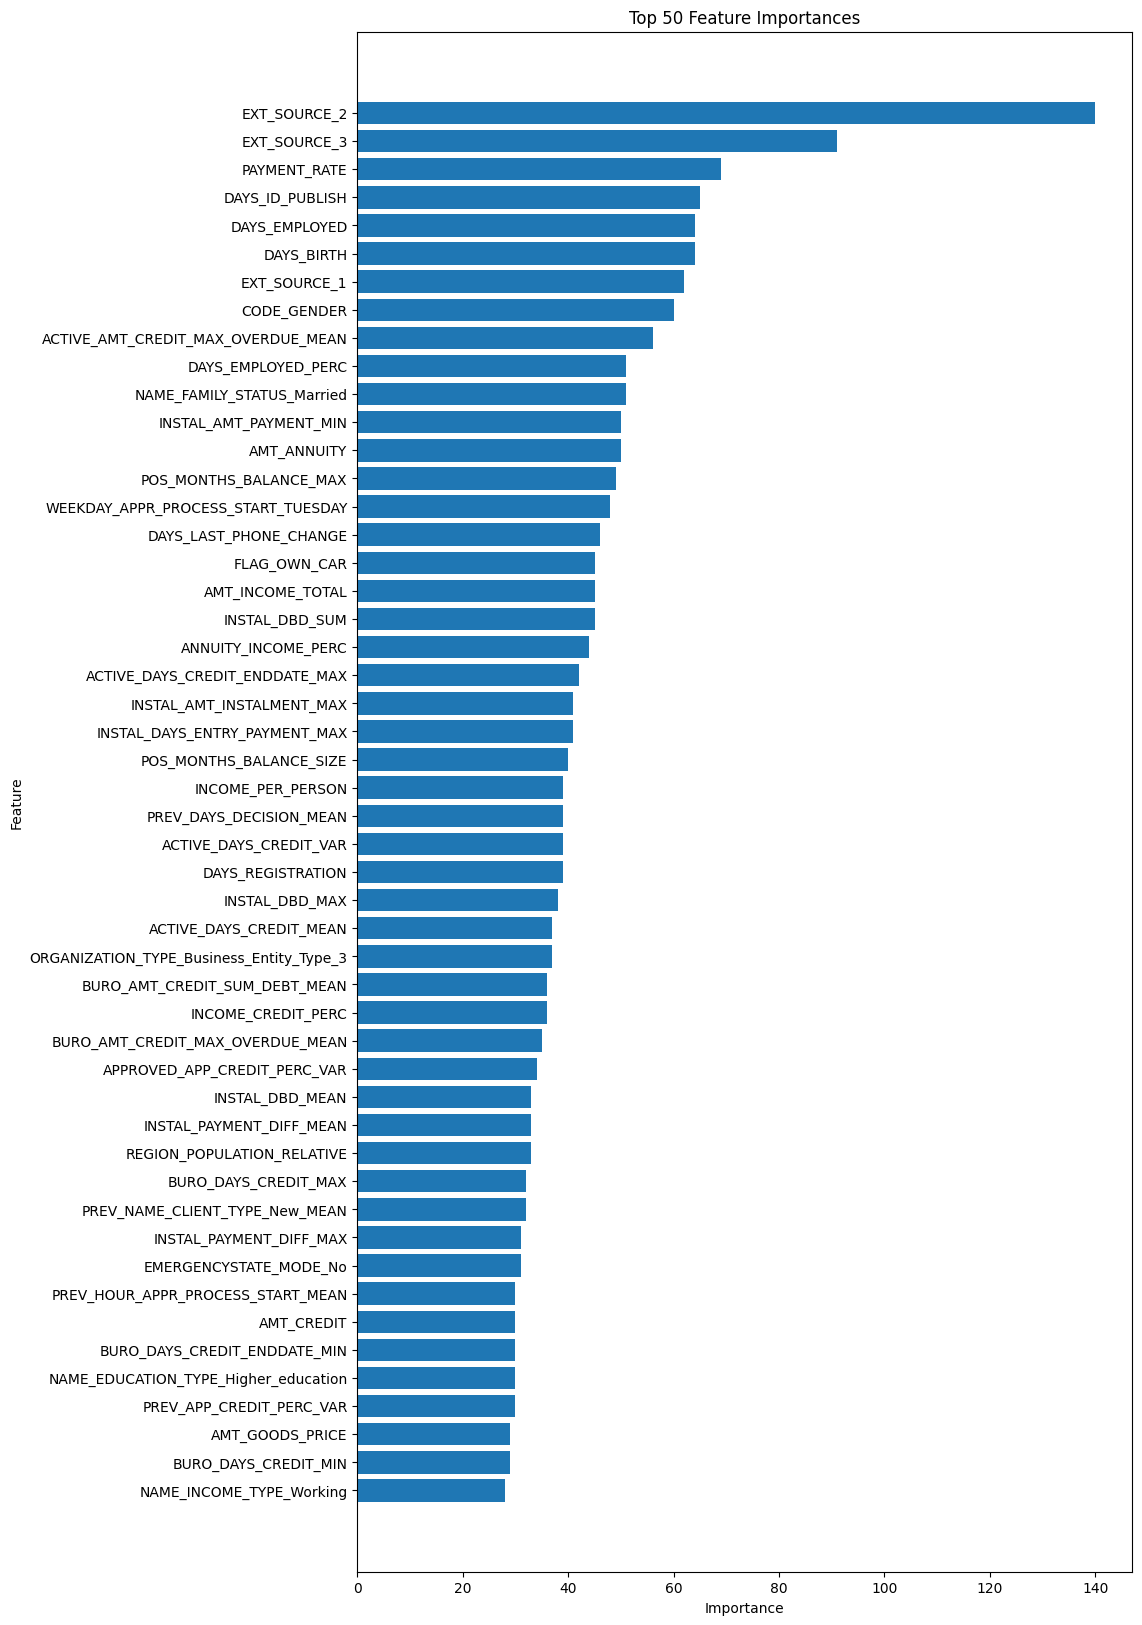

In [66]:
#la visualisation de l'importance des features

#uniquement les 50 premières features par importance
top_50_features = importance_df.head(50)

plt.figure(figsize=(10, 20))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
#pour que les plus importantes soient en haut
plt.gca().invert_yaxis()  
plt.show()

Division initiale des données :

Les données sont divisées en 80% pour l'entraînement (X_restant, y_restant) et 20% pour les nouvelles données à prédire (X_nouveaux_clients, y_nouveaux_clients).
Enregistrement du scaler :

Le scaler (StandardScaler) est sauvegardé en tant que scaler.pkl avec joblib.dump(scaler, 'scaler.pkl') pour être utilisé dans l'API pour normaliser les futures données d'entrée.
Optimisation des hyperparamètres :

Optuna est utilisé pour optimiser les hyperparamètres avec SMOTE et validation croisée sur une petite partie des données d'entraînement initial (20%).
Entraînement final :

Une fois les meilleurs hyperparamètres trouvés via Optuna, le modèle final est entraîné sur les 80% restants des données d'entraînement (X_train_final et y_train_final) avec SMOTE appliqué pour équilibrer les classes.
Enregistrement du modèle final :

Le modèle final est enregistré en tant que model.pkl pour être utilisé dans l'API de prédiction.
Sauvegarde des résultats :

Les résultats sont sauvegardés dans un fichier CSV (results_LGM.csv), et un affichage stylisé des scores est préparé pour les visualiser.
Utilisation des fichiers model.pkl et scaler.pkl pour l'API de prédiction
Lorsque vous devrez utiliser ces fichiers pour prédire de nouvelles données via une API, vous pourrez simplement les charger avec joblib :

In [67]:
nouveaux_clients = pd.read_csv('nouveaux_clients.csv', sep= ',')
nouveaux_clients

FileNotFoundError: [Errno 2] No such file or directory: 'nouveaux_clients.csv'